In [21]:
import os
import xarray as xr
import numpy as np

# === Path Settings ===
region = "WET"
recovery_period = 3  # Months
input_file = rf"Data - Modelling\Region_Monthly_DB\2. Reg_Combined\{region}_Combined.nc"
output_file = rf"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\{region}_Combined_Consecutive.nc"

# === Load Dataset ===
ds = xr.open_dataset(input_file)
print(f"✅ Loaded Region File: {input_file}")

# === Threshold Settings ===
spi_threshold = -1.0
recovery_threshold = -0.5

# === Initialize Output ===
spi_all = ds["spi_1"].values
consecutive_drought = np.full_like(spi_all, np.nan)
valid_mask = ~np.isnan(spi_all)

# === Loop Over Grid Points ===
for lat in range(spi_all.shape[1]):
    for lon in range(spi_all.shape[2]):
        if np.isnan(spi_all[:, lat, lon]).all():
            continue

        spi_series = spi_all[:, lat, lon]
        consecutive_series = np.zeros_like(spi_series)

        in_drought = False
        recovery_start_idx = None
        drought_start_idx = None

        for t in range(1, len(spi_series)):
            if np.isnan(spi_series[t]):
                continue

            if spi_series[t] <= spi_threshold:
                if not in_drought:
                    if recovery_start_idx is not None and (t - recovery_start_idx) <= recovery_period:
                        # ✅ Consecutive drought starts here
                        consecutive_series[t] = 1
                    # Update drought state
                    drought_start_idx = t
                    in_drought = True
                    recovery_start_idx = None
                # Do NOT label continuation months
            else:
                if in_drought and spi_series[t] >= recovery_threshold:
                    # ✅ Recovery starts
                    recovery_start_idx = t
                    in_drought = False

        # Assign result for this grid cell
        consecutive_drought[:, lat, lon] = consecutive_series

# === Add to Dataset and Save ===
ds["consecutive_drought"] = (("time", "lat", "lon"), np.where(valid_mask, consecutive_drought, np.nan))
ds.to_netcdf(output_file)
print(f"✅ Saved Labeled Region File: {output_file}")

✅ Loaded Region File: Data - Modelling\Region_Monthly_DB\2. Reg_Combined\WET_Combined.nc
✅ Saved Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\WET_Combined_Consecutive.nc


In [18]:
import xarray as xr
import numpy as np
import pandas as pd

# === File and Location Settings ===
input_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\CYP_Combined_Consecutive.nc"
lat_idx = 25  # Change as needed
lon_idx = 20

# === Drought Thresholds ===
spi_threshold = -1.0
recovery_threshold = -0.5
recovery_period = 3  # In months (adjust per region if needed)

# === Load Dataset ===
ds = xr.open_dataset(input_file)
spi_series = ds["spi_1"][:, lat_idx, lon_idx].values
consec_series = ds["consecutive_drought"][:, lat_idx, lon_idx].values
time_series = pd.to_datetime(ds["time"].values)

# === Track and Record Events ===
records = []
in_drought = False
recovery_start = None
recovery_start_idx = None
drought_start_month = None

for t in range(1, len(spi_series)):
    if np.isnan(spi_series[t]):
        continue

    if spi_series[t] <= spi_threshold:
        if not in_drought:
            if recovery_start is not None and (t - recovery_start_idx) <= recovery_period:
                # This is a consecutive drought
                records.append({
                    "Drought Start": drought_start_month.strftime("%Y-%m"),  # KEEP original
                    "Recovery Start": recovery_start.strftime("%Y-%m"),
                    "Consecutive Drought Month": time_series[t].strftime("%Y-%m")
                })
            else:
                # New independent drought
                drought_start_month = time_series[t]
            in_drought = True
            recovery_start = None
            recovery_start_idx = None
    else:
        if in_drought:
            if spi_series[t] >= recovery_threshold:
                recovery_start = time_series[t]
                recovery_start_idx = t
                in_drought = False

# === Print Table ===
df = pd.DataFrame(records)
if df.empty:
    print("No consecutive droughts detected at the selected location.")
else:
    print("\nConsecutive Drought Events at Location (lat_idx={}, lon_idx={}):".format(lat_idx, lon_idx))
    print(df.to_string(index=False))



Consecutive Drought Events at Location (lat_idx=25, lon_idx=20):
Drought Start Recovery Start Consecutive Drought Month
      2002-06        2002-08                   2002-09
      2007-05        2007-06                   2007-07
      2008-05        2008-07                   2008-08
      2008-05        2008-09                   2008-10
      2012-06        2012-07                   2012-08


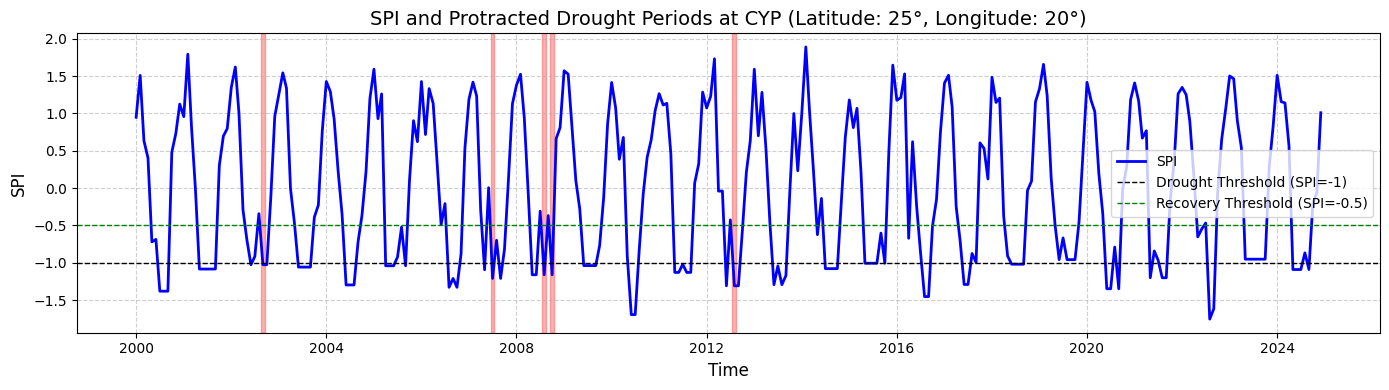

In [17]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd

# === Load the Optimized Consecutive Drought Labeled File ===
input_file = rf"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(input_file)

# Extract SPI and Consecutive Drought Data
spi_data = ds["spi_1"].values
consecutive_drought = ds["consecutive_drought"].values
time = pd.to_datetime(ds["time"].values)  # Convert to datetime if available

# Select a specific location (lat, lon) for visualization
lat_idx = 25
lon_idx = 20

# Extract time series
spi_series = spi_data[:, lat_idx, lon_idx]
consec_series = consecutive_drought[:, lat_idx, lon_idx]

# Mask invalid values (NaNs)
valid_mask = ~np.isnan(spi_series)
spi_series = spi_series[valid_mask]
consec_series = consec_series[valid_mask]
time = time[valid_mask]

# Plotting
fig, ax = plt.subplots(figsize=(14, 4))

# Plot SPI
ax.plot(time, spi_series, label='SPI', color='blue', linewidth=2)

# Highlight consecutive drought periods
for i in range(len(consec_series)):
    if consec_series[i] == 1:
        ax.axvspan(time[i] - pd.Timedelta(days=15), time[i] + pd.Timedelta(days=15),
                   color='red', alpha=0.3)

# Add horizontal threshold line for SPI drought threshold
ax.axhline(-1.0, color='black', linestyle='--', linewidth=1, label='Drought Threshold (SPI=-1)')

# Add horizontal threshold line for SPI drought threshold
ax.axhline(-0.5, color='green', linestyle='--', linewidth=1, label='Recovery Threshold (SPI=-0.5)')

# Plot formatting
ax.set_title('SPI and Protracted Drought Periods at CYP (Latitude: 25°, Longitude: 20°)', fontsize=14)
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('SPI', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.legend()
plt.tight_layout()
plt.show()


✅ Loaded Labeled Region File: Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\NET_Combined_Consecutive.nc


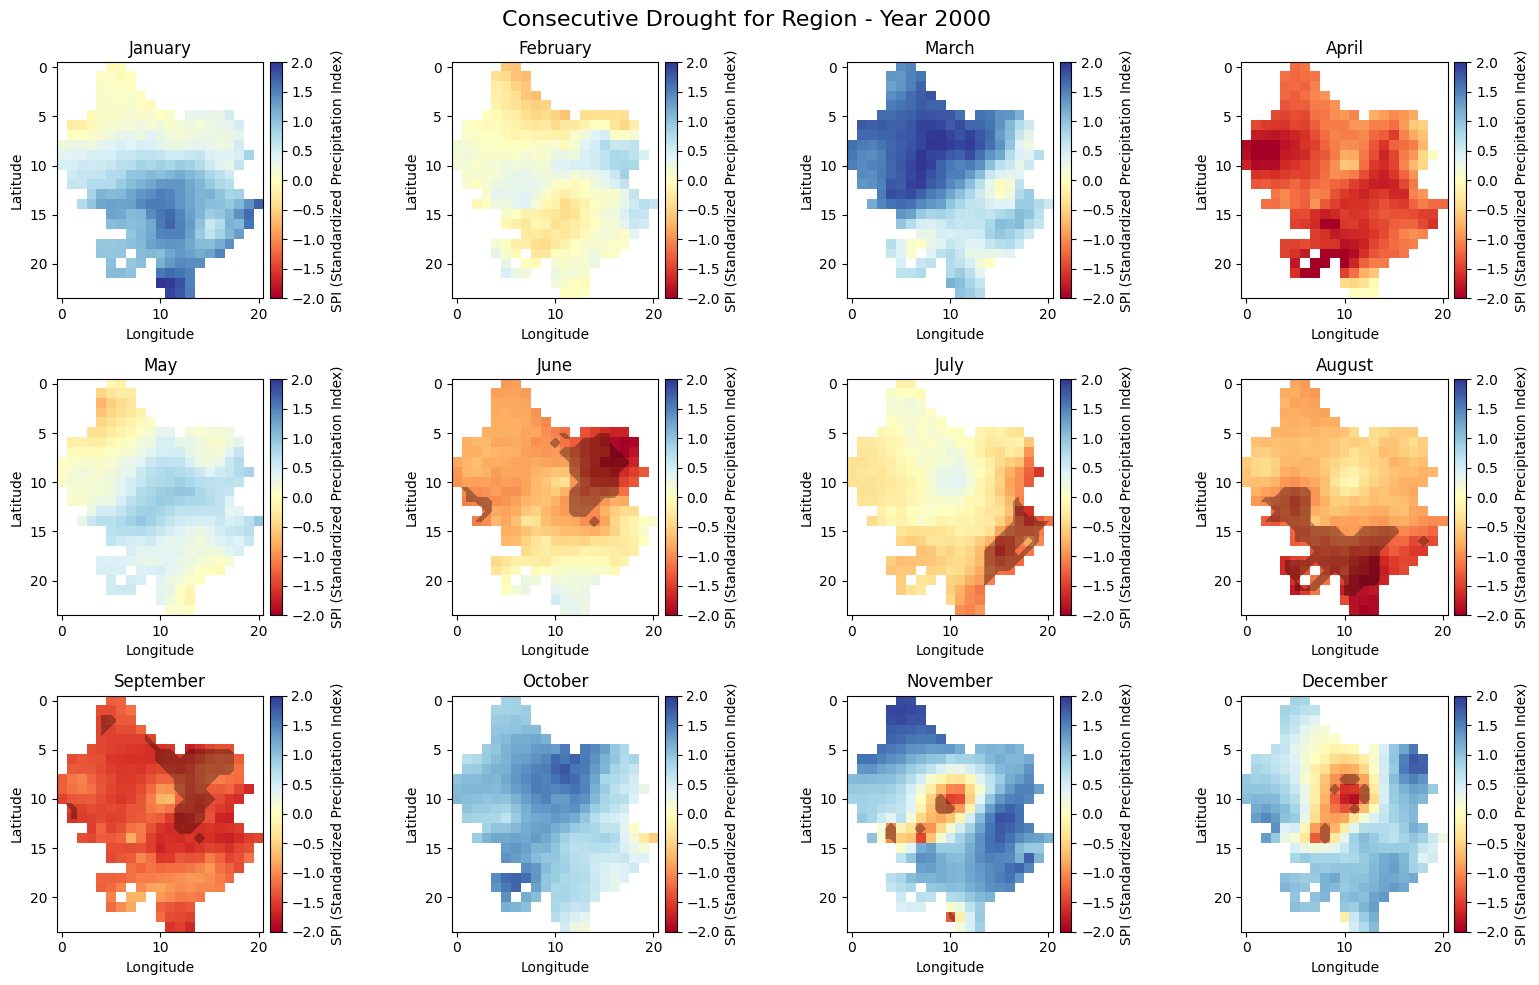

In [163]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


region = "NET"
# === Load the Labeled Region File ===
labeled_file = rf"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\{region}_Combined_Consecutive.nc"  # Change this to your file path
ds = xr.open_dataset(labeled_file)
print("✅ Loaded Labeled Region File:", labeled_file)

# === Select the first year for visualization ===
first_year = ds.time.dt.year[0].item()
year_data = ds.sel(time=str(first_year))

# === Visualization Setup ===
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
fig.suptitle(f"Consecutive Drought for Region - Year {first_year}", fontsize=16)

# === Plot SPI + Consecutive Drought Overlay for Each Month ===
for i, month in enumerate(year_data.time[:12]):
    ax = axes[i // 4, i % 4]
    month_data = year_data.sel(time=month)

    # === Plot SPI ===
    spi = month_data["spi_1"].values
    spi_masked = np.ma.masked_where(np.isnan(spi), spi)

    spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2)
    ax.set_title(str(month.dt.strftime('%B').item()))

    # Axis labels
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # === Overlay Consecutive Droughts ===
    consecutive = month_data["consecutive_drought"].values
    ax.contourf(consecutive, levels=[0.5, 1], colors='black', alpha=0.3)

    # === Colorbar (SPI) for each subplot ===
    cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
    cbar.set_label("SPI (Standardized Precipitation Index)")

plt.tight_layout()
plt.show()


In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

# === List of Region Codes (Update with your actual region codes) ===
regions = [
    "BRB", "CHC", "CQC", "CYP", "DEU", "EIU", "GUP",
    "MGD", "MUL", "NET", "NWH", "SEQ", "WET"
]

# === Directory Path ===
base_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02"

# === Loop Through Regions ===
for region in regions:
    try:
        labeled_file = os.path.join(base_path, f"{region}_Combined_Consecutive.nc")
        ds = xr.open_dataset(labeled_file)
        print(f"✅ Loaded: {region}")

        # Select the first year
        first_year = ds.time.dt.year[0].item()
        year_data = ds.sel(time=str(first_year))

        # Create plots for each region
        fig, axes = plt.subplots(3, 4, figsize=(16, 10))
        fig.suptitle(f"{region} - Consecutive Drought (Year {first_year})", fontsize=16)

        for i, month in enumerate(year_data.time[:12]):
            ax = axes[i // 4, i % 4]
            month_data = year_data.sel(time=month)

            # SPI plot
            spi = month_data["spi_1"].values
            spi_masked = np.ma.masked_where(np.isnan(spi), spi)
            spi_plot = ax.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2)
            ax.set_title(str(month.dt.strftime('%B').item()))
            ax.set_xlabel("Longitude")
            ax.set_ylabel("Latitude")

            # Consecutive drought overlay
            consecutive = month_data["consecutive_drought"].values
            ax.contourf(consecutive, levels=[0.5, 1], colors='blue', alpha=0.3)

            # Colorbar
            cbar = fig.colorbar(spi_plot, ax=ax, orientation="vertical", fraction=0.05, pad=0.02)
            cbar.set_label("SPI")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    except FileNotFoundError:
        print(f"❌ File not found for region: {region}")
    except Exception as e:
        print(f"❌ Error processing {region}: {e}")


✅ Merged region: BRB
✅ Merged region: CHC
✅ Merged region: CQC
✅ Merged region: CYP
✅ Merged region: DEU
✅ Merged region: EIU
✅ Merged region: GUP
✅ Merged region: MGD
✅ Merged region: MUL
✅ Merged region: NET
✅ Merged region: NWH
✅ Merged region: SEQ
✅ Merged region: WET


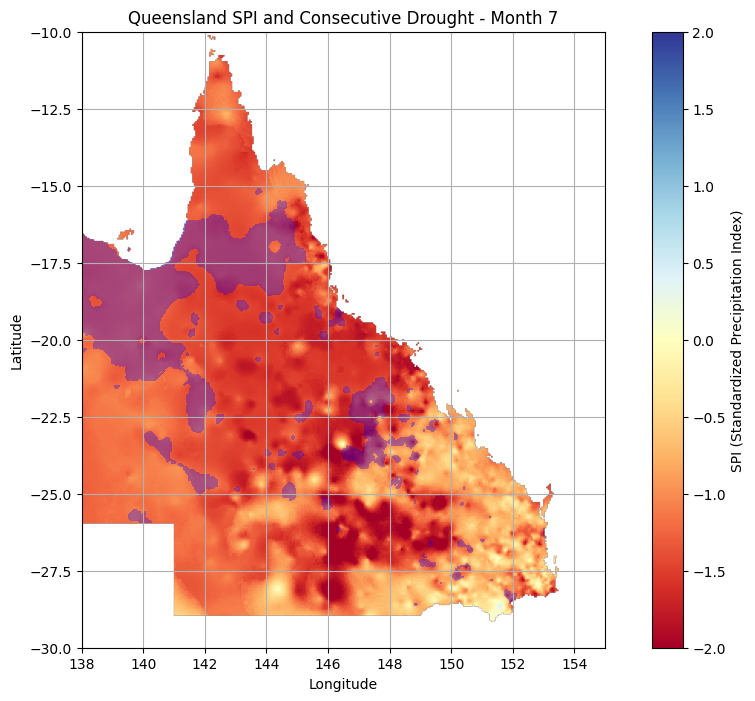

In [158]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os

# === Queensland Bounding Box and Grid Setup ===
lat_min, lat_max = -30.0, -10.0
lon_min, lon_max = 138.0, 155.0
res = 0.05  # resolution in degrees (~5km)

lats = np.arange(lat_min, lat_max + res, res)
lons = np.arange(lon_min, lon_max + res, res)

# Create a mesh for final global grid
spi_grid = np.full((len(lats), len(lons)), np.nan)
consec_grid = np.full((len(lats), len(lons)), np.nan)

# === Region List and Path ===
regions = [
    "BRB", "CHC", "CQC", "CYP", "DEU", "EIU", "GUP",
    "MGD", "MUL", "NET", "NWH", "SEQ", "WET"
]
base_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02"

# === Select target month (e.g., January - 0) ===
target_month_index = 6

# === Fill Global Grid with Regional Data ===
for region in regions:
    try:
        ds = xr.open_dataset(os.path.join(base_path, f"{region}_Combined_Consecutive.nc"))
        first_year = ds.time.dt.year[0].item()
        ds = ds.sel(time=str(first_year))
        
        # Extract SPI and drought for target month
        spi = ds["spi_1"].isel(time=target_month_index).values
        cons = ds["consecutive_drought"].isel(time=target_month_index).values
        lat = ds.lat.values
        lon = ds.lon.values

        # Place into full Queensland grid
        for i in range(len(lat)):
            for j in range(len(lon)):
                lat_idx = np.abs(lats - lat[i]).argmin()
                lon_idx = np.abs(lons - lon[j]).argmin()
                if not np.isnan(spi[i, j]):
                    spi_grid[lat_idx, lon_idx] = spi[i, j]
                if not np.isnan(cons[i, j]):
                    consec_grid[lat_idx, lon_idx] = cons[i, j]

        print(f"✅ Merged region: {region}")
    except Exception as e:
        print(f"❌ Error processing {region}: {e}")

# === Plot Final Combined Map ===
plt.figure(figsize=(12, 8))
spi_masked = np.ma.masked_invalid(spi_grid)
im = plt.imshow(spi_masked, cmap="RdYlBu", vmin=-2, vmax=2,
                extent=[lon_min, lon_max, lat_min, lat_max], origin='lower')
plt.contourf(consec_grid, levels=[0.5, 1], colors='blue', alpha=0.3,
             extent=[lon_min, lon_max, lat_min, lat_max])
plt.colorbar(im, label="SPI (Standardized Precipitation Index)")
plt.title(f"Queensland SPI and Consecutive Drought - Month {target_month_index + 1}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


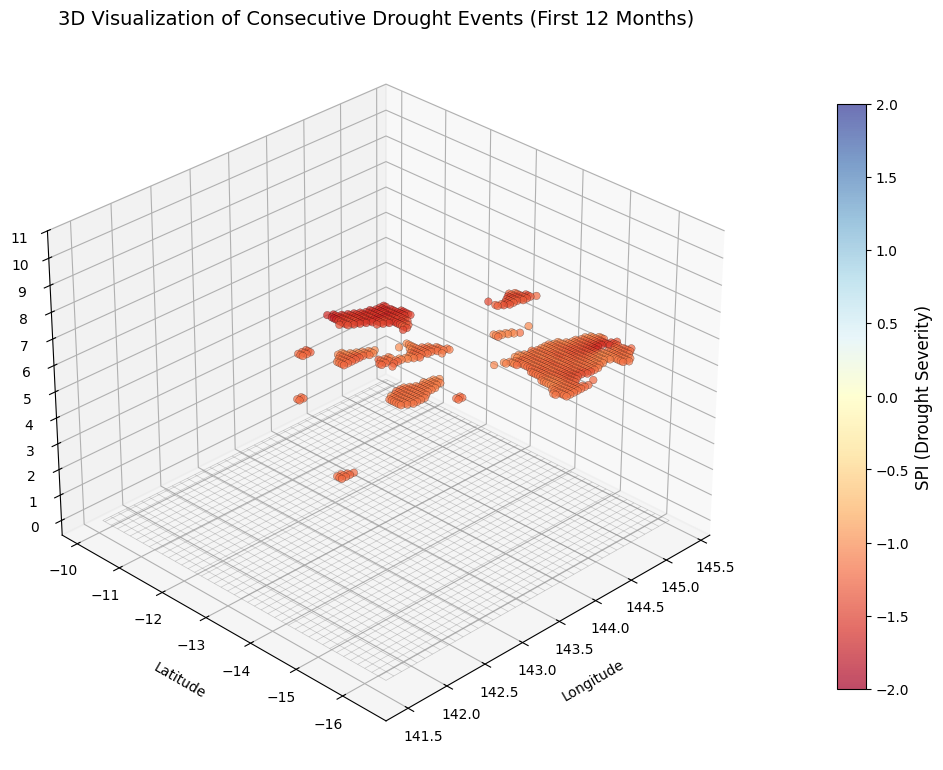

In [137]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Extract coordinate and time information
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values[12:24]  # First 12 months
ds = ds.sel(time=time)

# Meshgrid for boundary plotting
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Prepare drought points
x_lons, y_lats, z_times, colors_spi = [], [], [], []

for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values

    # Mask for valid drought events
    mask = (consecutive == 1) & (~np.isnan(spi))

    # Coordinates of drought pixels
    x_lons.extend(lon_grid[mask])
    y_lats.extend(lat_grid[mask])
    z_times.extend([t_index] * np.sum(mask))
    colors_spi.extend(spi[mask])

# Convert to arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

# === 3D Plot ===
fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111, projection='3d')

# 3D scatter: Drought events
sc = ax.scatter(x_lons, y_lats, z_times, c=colors_spi, cmap="RdYlBu",
                vmin=-2, vmax=2, s=30, edgecolors='k', linewidths=0.2, alpha=0.7)

# Region boundary wireframe (z=bottom layer)
ax.plot_wireframe(lon_grid, lat_grid, np.zeros_like(lon_grid), color='gray', linewidth=0.5, alpha=0.4)

# Axis labels and ticks
ax.set_xlabel("Longitude", labelpad=10)
ax.set_ylabel("Latitude", labelpad=10)
ax.set_zlabel("Month Index", labelpad=10)
ax.set_zticks(range(12))
ax.set_title("3D Visualization of Consecutive Drought Events (First 12 Months)", fontsize=14)

# View and grid
ax.view_init(elev=30, azim=225)
ax.grid(True)

# Colorbar
cb = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
cb.set_label("SPI (Drought Severity)", fontsize=12)

plt.tight_layout()
plt.show()


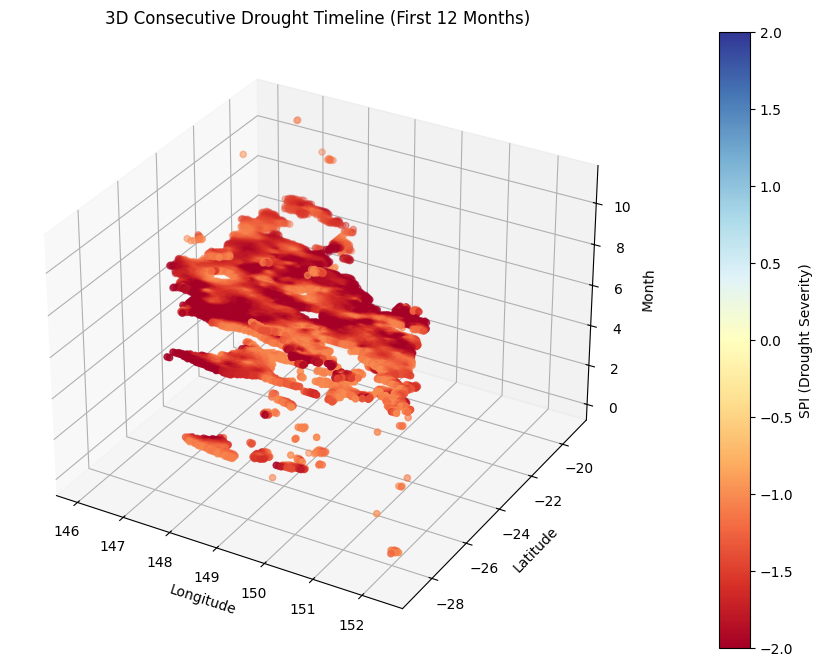

In [123]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\BRB_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Get lon, lat, time
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values

# Use only first 12 months
time = time[12:24]
ds = ds.sel(time=time)

# Build meshgrid for lat/lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Initialize lists for 3D scatter data
x_lons = []
y_lats = []
z_times = []
colors_spi = []

# Iterate over 12 time steps
for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values

    # Find indices where drought occurred
    mask = (consecutive == 1) & (~np.isnan(spi))

    # Extract coordinates and SPI
    x_lons.extend(lon_grid[mask])
    y_lats.extend(lat_grid[mask])
    z_times.extend([t_index] * np.sum(mask))
    colors_spi.extend(spi[mask])  # Use SPI as drought severity (can change to SSI or DI)

# Convert to numpy arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
sc = ax.scatter(x_lons, y_lats, z_times, c=colors_spi, cmap="RdYlBu", vmin=-2, vmax=2)

# Labels and axis setup
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Month")
ax.set_title("3D Consecutive Drought Timeline (First 12 Months)")

# Add colorbar
cb = plt.colorbar(sc, pad=0.1)
cb.set_label("SPI (Drought Severity)")

plt.show()


Text(0.5, 0.92, '3D Consecutive Drought Timeline (First 12 Months)')

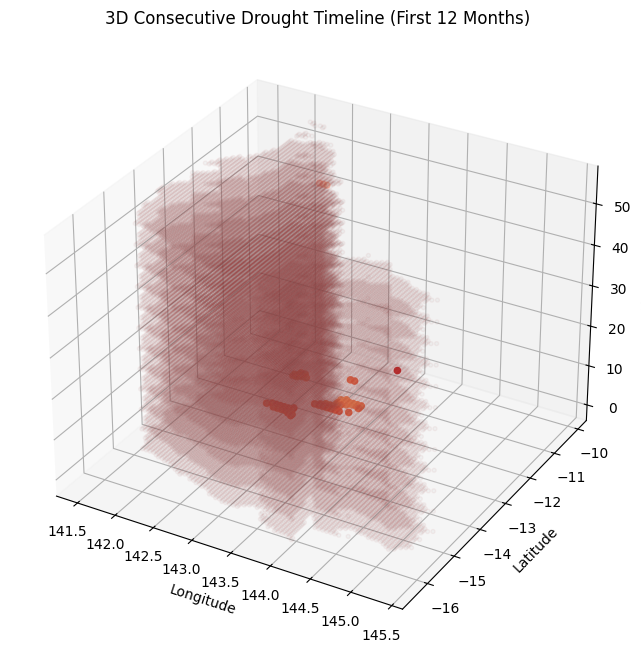

In [97]:
import xarray as xr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Load dataset
labeled_file = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02\CYP_Combined_Consecutive.nc"
ds = xr.open_dataset(labeled_file)

# Get lon, lat, time
lon = ds.lon.values
lat = ds.lat.values
time = ds.time.values[0:12]  # Use months 25–36
ds = ds.sel(time=time)

# Build meshgrid for lat/lon
lon_grid, lat_grid = np.meshgrid(lon, lat)

# Initialize lists for 3D scatter data
x_lons = []
y_lats = []
z_times = []
colors_spi = []

# SPI background arrays
x_spi_all = []
y_spi_all = []
z_spi_all = []
spi_all_values = []

spacing = 5  # Vertical separation between months

# Iterate over 12 time steps
for t_index, t in enumerate(time):
    spi = ds["spi_1"].isel(time=t_index).values
    consecutive = ds["consecutive_drought"].isel(time=t_index).values

    valid_spi = ~np.isnan(spi)
    drought_mask = (consecutive == 1) & valid_spi

    # Background: all valid SPI pixels
    x_spi_all.extend(lon_grid[valid_spi])
    y_spi_all.extend(lat_grid[valid_spi])
    z_spi_all.extend([t_index * spacing] * np.sum(valid_spi))
    spi_all_values.extend(spi[valid_spi])

    # Foreground: consecutive drought only
    x_lons.extend(lon_grid[drought_mask])
    y_lats.extend(lat_grid[drought_mask])
    z_times.extend([t_index * spacing] * np.sum(drought_mask))
    colors_spi.extend(spi[drought_mask])

# Convert to numpy arrays
x_lons = np.array(x_lons)
y_lats = np.array(y_lats)
z_times = np.array(z_times)
colors_spi = np.array(colors_spi)

x_spi_all = np.array(x_spi_all)
y_spi_all = np.array(y_spi_all)
z_spi_all = np.array(z_spi_all)

# Plotting in 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# SPI background (gray points)
ax.scatter(
    x_spi_all, y_spi_all, z_spi_all,
    color='gray', s=8, alpha=0.05,
    edgecolors='brown', label='All SPI values'
)

# Consecutive drought points (colored by SPI)
sc = ax.scatter(
    x_lons, y_lats, z_times,
    c=colors_spi, cmap="RdYlBu", vmin=-2, vmax=2
)

# Labels and axis setup
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Month")
ax.set_title("3D Consecutive Drought Timeline (First 12 Months)")

# Fix Z-axis (


In [ ]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# === Directory containing all region files ===
folder_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02"

# === Loop through all NetCDF files in the folder ===
for file_name in os.listdir(folder_path):
    if not file_name.endswith(".nc"):
        continue  # Skip non-NetCDF files

    region_name = file_name.split("_")[0]
    file_path = os.path.join(folder_path, file_name)

    print(f"📂 Processing {region_name} ...")

    ds = xr.open_dataset(file_path)

    # Extract coords and select desired time window
    lon = ds.lon.values
    lat = ds.lat.values
    time = ds.time.values[12:24]  # 12 months starting from month 13
    ds = ds.sel(time=time)

    lon_grid, lat_grid = np.meshgrid(lon, lat)

    x_lons, y_lats, z_times, colors_spi = [], [], [], []

    for t_index, t in enumerate(time):
        spi = ds["spi_1"].isel(time=t_index).values
        consecutive = ds["consecutive_drought"].isel(time=t_index).values

        mask = (consecutive == 1) & (~np.isnan(spi))

        x_lons.extend(lon_grid[mask])
        y_lats.extend(lat_grid[mask])
        z_times.extend([t_index] * np.sum(mask))
        colors_spi.extend(spi[mask])

    # Skip empty plots
    if len(x_lons) == 0:
        print(f"⚠️ No drought events found in {region_name}, skipping.")
        continue

    x_lons = np.array(x_lons)
    y_lats = np.array(y_lats)
    z_times = np.array(z_times)
    colors_spi = np.array(colors_spi)

    # === Plot ===
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection='3d')

    sc = ax.scatter(x_lons, y_lats, z_times, c=colors_spi, cmap="RdYlBu",
                    vmin=-2, vmax=2, s=30, edgecolors='k', linewidths=0.2, alpha=0.5)

    ax.plot_wireframe(lon_grid, lat_grid, np.zeros_like(lon_grid),
                      color='gray', linewidth=0.3, alpha=0.4)

    ax.set_xlabel("Longitude", labelpad=10)
    ax.set_ylabel("Latitude", labelpad=10)
    ax.set_zlabel("Month Index", labelpad=10)
    ax.set_zticks(range(12))
    ax.set_title(f"3D Consecutive Drought Events - {region_name}", fontsize=14)

    ax.view_init(elev=30, azim=225)
    ax.grid(True)

    cb = plt.colorbar(sc, ax=ax, shrink=0.5, pad=0.1)
    cb.set_label("SPI (Drought Severity)", fontsize=12)

    plt.tight_layout()
    plt.show()


In [ ]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import find_contours

# === Folder with all region .nc files ===
folder_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02"

# === Loop through all NetCDF region files ===
for file_name in os.listdir(folder_path):
    if not file_name.endswith(".nc"):
        continue  # Skip non-NetCDF files

    region_name = file_name.split("_")[0]
    file_path = os.path.join(folder_path, file_name)
    print(f"\n📂 Processing: {region_name}")

    ds = xr.open_dataset(file_path)

    # Select time window (13th to 24th month)
    time = ds.time.values[12:24]
    ds = ds.sel(time=time)

    lon = ds.lon.values
    lat = ds.lat.values
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    x_lons, y_lats, z_times, colors_spi = [], [], [], []

    for t_index, t in enumerate(time):
        spi = ds["spi_1"].isel(time=t_index).values
        consecutive = ds["consecutive_drought"].isel(time=t_index).values
        mask = (consecutive == 1) & (~np.isnan(spi))

        x_lons.extend(lon_grid[mask])
        y_lats.extend(lat_grid[mask])
        z_times.extend([t_index] * np.sum(mask))
        colors_spi.extend(spi[mask])

    if len(x_lons) == 0:
        print(f"⚠️ No drought events in {region_name}, skipping.")
        continue

    x_lons = np.array(x_lons)
    y_lats = np.array(y_lats)
    z_times = np.array(z_times)
    colors_spi = np.array(colors_spi)

    # === Begin Plot ===
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # 3D scatter: drought events
    sc = ax.scatter(
        x_lons, y_lats, z_times,
        c=colors_spi, cmap="RdYlBu", vmin=-2, vmax=2,
        s=30, edgecolors='k', linewidths=0.2, alpha=0.75
    )

    # === REGION BORDER from data (non-NaN mask) ===
    spi_base = ds["spi_1"].isel(time=0).values
    mask = ~np.isnan(spi_base)
    contours = find_contours(mask.astype(float), level=0.5)

    for contour in contours:
        row_idx = contour[:, 0]
        col_idx = contour[:, 1]

        # Flip lat if needed
        lat_vals = np.interp(row_idx, np.arange(len(lat)), lat[::-1])
        lon_vals = np.interp(col_idx, np.arange(len(lon)), lon)

        ax.plot(lon_vals, lat_vals, zs=0, zdir='z',
                color='black', linewidth=1.0, alpha=0.9, label='Region Border')

    # === Axis formatting ===
    ax.set_xlabel("Longitude", labelpad=10)
    ax.set_ylabel("Latitude", labelpad=10)
    ax.set_zlabel("Month Index", labelpad=10)
    ax.set_zticks(range(12))
    ax.set_zticklabels([str(i + 1) for i in range(12)])
    ax.set_title(f"3D Consecutive Drought Events – {region_name}", fontsize=14)
    ax.view_init(elev=30, azim=225)
    ax.grid(True)

    # === Colorbar ===
    cb = plt.colorbar(sc, ax=ax, shrink=0.55, pad=0.1)
    cb.set_label("SPI (Drought Severity)", fontsize=12)
    cb.ax.tick_params(labelsize=10)

    # === Finalize ===
    plt.tight_layout()
    plt.show()


In [61]:
import xarray as xr
import os
import glob

# Folder path where all NetCDF files are located
folder_path = r"Data - Modelling\Region_Monthly_DB\3. Con Drought Labelled Files_v02"

# Get all .nc files in the folder
nc_files = glob.glob(os.path.join(folder_path, "*.nc"))

# Store results in a list of tuples
results = []

for file in nc_files:
    try:
        # Extract the filename and region name (first word)
        filename = os.path.basename(file)
        region = filename.split('_')[0]  # Assumes filename starts with region name

        # Load dataset and get the variable
        ds = xr.open_dataset(file)
        drought_data = ds['consecutive_drought']

        # Count the number of times the value 1 appears
        count_ones = (drought_data == 1).sum().item()

        # Append result
        results.append((region, count_ones))
    except Exception as e:
        print(f"Error processing {file}: {e}")

# Print the results as a table
print(f"{'Region':<10} | {'Count of 1s':>12}")
print("-" * 25)
for region, count in results:
    print(f"{region:<10} | {count:>12}")


Region     |  Count of 1s
-------------------------
BRB        |       187163
CHC        |       149081
CQC        |         5110
CYP        |        14233
DEU        |        41966
EIU        |        40568
GUP        |        53252
MGD        |       128950
MUL        |       132443
NET        |         4068
NWH        |        28213
SEQ        |        26202
WET        |         5351
